# Preliminary Data Analysis
To determine the demand & renewable generation curve

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:

# Set working directory as current directory
# working_path = "C:/Users/Simone Pagliuca/Documents/GitHub/INRE"
working_path = "C:/Users/Simo/Documents/GitHub/INRE"
# Load the CSV
path = working_path + "/Ext_Data/FILTERED_db.csv"
df = pd.read_csv(path, dtype=str)

data_save = ""

energy_classes = ["A4", "A3", "A2", "A1", "B", "C", "D", "E", "F", "G"]

## Preparatory Work
Start by trying to scale teh data form my small dataset to be representative of the total share of buildings.  
Do this by heated area

In [33]:
# Convert heated area to float and filter outliers
heated_area = df['SUPERF_UTILE_RISCALDATA'].astype(float)
limit = 600 # Do not consider buildings with heated area greater than 600 m2
print(f"Number of Ouliars excluded {len(heated_area[heated_area >= limit])}")
print(f"Number of buildings considered {len(heated_area[heated_area < limit])}")
print(f"Total number of records: {len(heated_area)}")
heated_area = heated_area[heated_area < limit]

# add this data to the data to save
data_save += f"Number of Ouliars excluded {len(heated_area[heated_area >= limit])}\n"
data_save += f"Number of buildings considered {len(heated_area[heated_area < limit])}\n"
data_save += f"Total number of records: {len(heated_area)}\n"

Number of Ouliars excluded 99
Number of buildings considered 68868
Total number of records: 68967


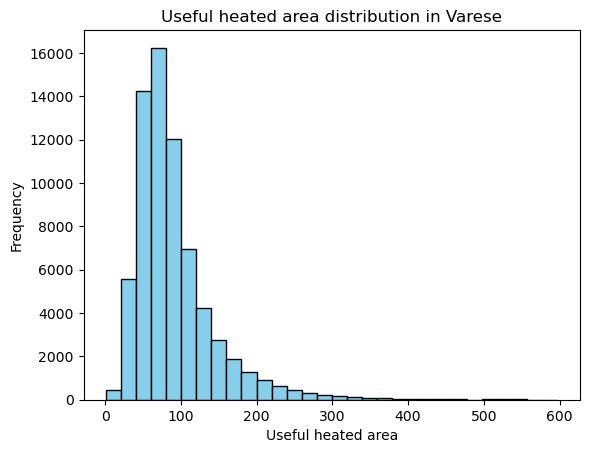

<Figure size 640x480 with 0 Axes>

In [34]:
# Create histogram to show the distribution of useful heated area
bin_counts, bin_edges = np.histogram(heated_area, bins=30)

# Plot histogram
plt.hist(heated_area, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Useful heated area")
plt.ylabel("Frequency")
plt.title("Useful heated area distribution in Varese")
plt.show()

# Save the histogram as a PNG file
plt.savefig(working_path + "/Exports/Useful_heated_area_distribution.png", dpi=300, bbox_inches='tight')

In [35]:
# Average heated area
average = heated_area.mean()
print(f"Average useful heated area in Varese: {average:.2f} m²")
total_area = heated_area.sum()
print(f"Total useful heated area in Varese: {total_area:.2f} m²")
print(f"Number of records: {len(heated_area)}")

Average useful heated area in Varese: 91.37 m²
Total useful heated area in Varese: 6292183.70 m²
Number of records: 68868


In [36]:
# Convert to float
df['EP_GL_NREN'] = df['EP_GL_NREN'].astype(float)

# Exclude top 1% globally
threshold = df['EP_GL_NREN'].quantile(0.99)
filtered_df = df[df['EP_GL_NREN'] <= threshold]

# Compute average per energy class
average_ep_gl_nren_by_class = filtered_df.groupby('CLASSE_ENERGETICA')['EP_GL_NREN'].mean()

# Print results
print("Average non-renewable energy consumption per energy class (excluding top 1%):")
print(average_ep_gl_nren_by_class)


Average non-renewable energy consumption per energy class (excluding top 1%):
CLASSE_ENERGETICA
A1     84.432191
A2     67.875927
A3     51.862467
A4     27.086805
B      98.048110
C     113.605301
D     141.887679
E     181.119989
F     240.148125
G     373.581310
Name: EP_GL_NREN, dtype: float64


Here we show the scaling factors that are used, we might have to touch them to make them more rapresentative of the reality

In [37]:
# Reference heated areas from the TERMOLOG simulations
refs = {
    'A4': 687,
    'A3': 210,
    'A2': 164,
    'A1': 164,
    'B': 306,
    'C': 254,
    'D': 347,
    'E': 306,
    'F': 155,
    'G': 311
}

# Correction factor: average area / each reference area
scaling_corr = {label: round(average / area, 2) for label, area in refs.items()}

# Display correction factors
print("/nScaling correction factors to match average heated area:")
for label in refs:
    print(f"{label}: Sup Disp = {refs[label]} m², CorrF = {scaling_corr[label]}")

# Add the data to save
data_save += "\nScaling correction factors to match average heated area:\n"
for label in refs:
    data_save += f"{label}: Sup Disp = {refs[label]} m², CorrF = {scaling_corr[label]}\n"

/nScaling correction factors to match average heated area:
A4: Sup Disp = 687 m², CorrF = 0.13
A3: Sup Disp = 210 m², CorrF = 0.44
A2: Sup Disp = 164 m², CorrF = 0.56
A1: Sup Disp = 164 m², CorrF = 0.56
B: Sup Disp = 306 m², CorrF = 0.3
C: Sup Disp = 254 m², CorrF = 0.36
D: Sup Disp = 347 m², CorrF = 0.26
E: Sup Disp = 306 m², CorrF = 0.3
F: Sup Disp = 155 m², CorrF = 0.59
G: Sup Disp = 311 m², CorrF = 0.29


### More data import

In [38]:
# Headers:
# CLASSE_ENERGETICA,EP_GL_NREN,Y,Z,EP_GL_REN,EMISSIONI_CO2,CONSUMI_ENERGIA_ELETTRICA,
# CONSUMI_GAS_NATURALE,CONSUMI_GPL,CONSUMI_CARBONE,CONSUMI_GASOLIO,
# CONSUMI_BIOMASSE_SOLIDE,CONSUMI_BIOMASSE_LIQUIDE,CONSUMI_BIOMASSE_GASSOSE,
# CONSUMI_SOLARE_FOTOVOLTAICO,CONSUMI_SOLARE_TERMICO,CONSUMI_EOLICO,
# CONSUMI_TELERISCALDAMENTO,CONSUMI_TELERAFFRESCAMENTO
# Divide by CLASSE_ENERGETICA
ep_gl_nren = df['EP_GL_NREN'].astype(float)
ep_gl_ren = df['EP_GL_REN'].astype(float)
electric = df['CONSUMI_ENERGIA_ELETTRICA'].astype(float)
gas = df['CONSUMI_GAS_NATURALE'].astype(float)
gpl = df['CONSUMI_GPL'].astype(float)
carbone = df['CONSUMI_CARBONE'].astype(float)
gasolio = df['CONSUMI_GASOLIO'].astype(float)
biomass = df['CONSUMI_BIOMASSE_SOLIDE'].astype(float) + df['CONSUMI_BIOMASSE_LIQUIDE'].astype(float) + df['CONSUMI_BIOMASSE_GASSOSE'].astype(float)

solare_fotovoltaico = df['CONSUMI_SOLARE_FOTOVOLTAICO'].astype(float)
solare_termico = df['CONSUMI_SOLARE_TERMICO'].astype(float)
eolico = df['CONSUMI_EOLICO'].astype(float)
teleriscaldamento = df['CONSUMI_TELERISCALDAMENTO'].astype(float)
teleraffrescamento = df['CONSUMI_TELERAFFRESCAMENTO'].astype(float)

# Sum and print results
print("/nTotal Annual energy consumption by source:")
print(f"Electricity: {electric.sum():.2f} kWh")
print(f"Natural Gas: {gas.sum():.2f} m³")
print(f"GPL: {gpl.sum():.2f} m³")
print(f"Coal: {carbone.sum():.2f} m³")
print(f"Diesel: {gasolio.sum():.2f} m³")
print(f"Biomass: {biomass.sum():.2f} m³")
print(f"Solar PV: {solare_fotovoltaico.sum():.2f} kWh")
print(f"Solar Thermal: {solare_termico.sum():.2f} kWh")
print(f"Wind: {eolico.sum():.2f} kWh")
print(f"District Heating: {teleriscaldamento.sum():.2f} kWh")
print(f"District Cooling: {teleraffrescamento.sum():.2f} kWh")

# Inidici di prestazione
print(f"EP GL NREN: {ep_gl_nren.sum():.2f} kWh/m²annum")
print(f"EP GL REN: {ep_gl_ren.sum():.2f} kWh/m²annum")

# Add the data to save
data_save += "\nTotal Annual energy consumption by source:\n"
data_save += f"Electricity: {electric.sum():.2f} kWh\n"
data_save += f"Natural Gas: {gas.sum():.2f} m³\n"
data_save += f"GPL: {gpl.sum():.2f} m³\n"
data_save += f"Coal: {carbone.sum():.2f} m³\n"
data_save += f"Diesel: {gasolio.sum():.2f} m³\n"
data_save += f"Biomass: {biomass.sum():.2f} m³\n"
data_save += f"Solar PV: {solare_fotovoltaico.sum():.2f} kWh\n"
data_save += f"Solar Thermal: {solare_termico.sum():.2f} kWh\n"
data_save += f"Wind: {eolico.sum():.2f} kWh\n"
data_save += f"District Heating: {teleriscaldamento.sum():.2f} kWh\n"
data_save += f"District Cooling: {teleraffrescamento.sum():.2f} kWh\n"
data_save += f"EP GL NREN: {ep_gl_nren.sum():.2f} kWh/m²annum\n"
data_save += f"EP GL REN: {ep_gl_ren.sum():.2f} kWh/m²annum\n"

/nTotal Annual energy consumption by source:
Electricity: 45391872.48 kWh
Natural Gas: 1039900848.93 m³
GPL: 1575706.00 m³
Coal: 0.00 m³
Diesel: 3630960.16 m³
Biomass: 10733968.00 m³
Solar PV: 15791020.00 kWh
Solar Thermal: 3671141.00 kWh
Wind: 0.00 kWh
District Heating: 6266882.00 kWh
District Cooling: 0.00 kWh
EP GL NREN: 17316775.22 kWh/m²annum
EP GL REN: 1283997.63 kWh/m²annum


## Evaluation of the Heating and Cooling systems
First the share of households with cooling systems

In [39]:
# Share of buildings with cooling
sup_raffrescata = df['SUPERF_UTILE_RAFFRESCATA'].astype(float)
# Count how many buildings have cooling
cooling_count = len(sup_raffrescata[sup_raffrescata > 0])
# Percentage of buildings with cooling
cooling_percentage = (cooling_count / len(df)) * 100
print(f"Percentage of buildings with cooling: {cooling_percentage:.2f}%")

# Add the data to save
data_save += f"\nPercentage of buildings with cooling: {cooling_percentage:.2f}%\n"

Percentage of buildings with cooling: 9.58%


Then identify those that have an heat pump installed

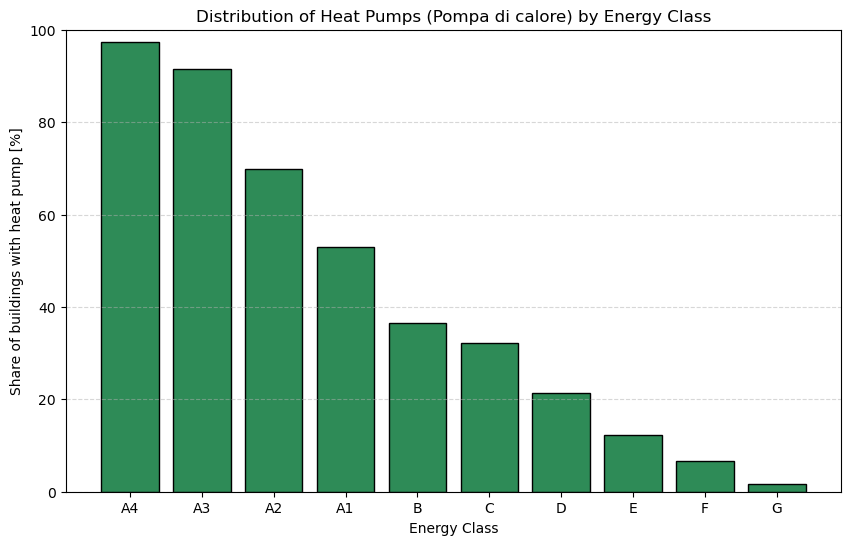

<Figure size 640x480 with 0 Axes>

In [40]:
# Identify all columns that refer to heat pumps
impianto_cols = [col for col in df.columns if 'TIPO_IMPIANTO' in col]

# Create a boolean mask for each row: True if at least one column has 'pompa di calore'
has_pdc = df[impianto_cols].apply(lambda row: row.str.lower().str.contains('pompa di calore', na=False).any(), axis=1)

# Get energy class for all rows
classe = df['CLASSE_ENERGETICA']

# Total buildings per class
total_by_class = classe.value_counts()

# Buildings with at least one heat pump per class
pdc_by_class = classe[has_pdc].value_counts()

# Reorder based on standard energy class order
total_by_class = total_by_class.reindex(energy_classes, fill_value=0)
pdc_by_class = pdc_by_class.reindex(energy_classes, fill_value=0)

# Calculate share
pdc_percentage = (pdc_by_class / total_by_class * 100).fillna(0)

# Plot result
plt.figure(figsize=(10, 6))
plt.bar(pdc_percentage.index, pdc_percentage.values, color='seagreen', edgecolor='black')
plt.xlabel("Energy Class")
plt.ylabel("Share of buildings with heat pump [%]")
plt.title("Distribution of Heat Pumps (Pompa di calore) by Energy Class")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Save the plot as a PNG file
plt.savefig(working_path + "/Exports/Heat_pumps_by_energy_class.png", dpi=300, bbox_inches='tight')

In [41]:
# Print the distribution
print("/nDistribution of heat pumps by energy class:")
for energy_class, percentage in pdc_percentage.items():
    print(f"{energy_class}: {percentage:.2f}%")

# Save the data to data_save
data_save += "\nDistribution of heat pumps by energy class:\n"
for energy_class, percentage in pdc_percentage.items():
    data_save += f"{energy_class}: {percentage:.2f}%\n"

/nDistribution of heat pumps by energy class:
A4: 97.40%
A3: 91.48%
A2: 69.84%
A1: 53.05%
B: 36.63%
C: 32.23%
D: 21.32%
E: 12.19%
F: 6.66%
G: 1.77%


## Evaluation of Photovoltaic Systems

Number of PV systems: 7889
Average PV power: 4.21 kW
Total PV power: 33225.55 kW


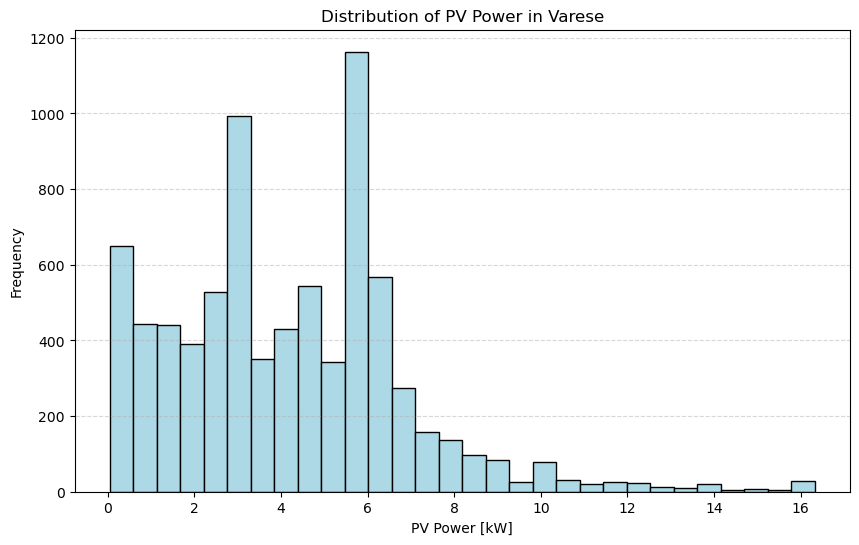

In [42]:
# Get energy class for all rows
classe = df['CLASSE_ENERGETICA']

# Identify rows with photovoltaic (PV) installed
has_pv = df['PFR_TIPO_IMPIANTO_1'] == "Fotovoltaico"
pv_power = df[has_pv]['PFR_POTENZA_NOMINALE_1'].astype(float)

# Get rid of the top 1% of PV power values
pv_power = pv_power[pv_power <= pv_power.quantile(0.99)]
print(f"Number of PV systems: {len(pv_power)}")
print(f"Average PV power: {pv_power.mean():.2f} kW")
print(f"Total PV power: {pv_power.sum():.2f} kW")

# Histogram of PV power
plt.figure(figsize=(10, 6))
plt.hist(pv_power, bins=30, color='lightblue', edgecolor='black')
plt.xlabel("PV Power [kW]")
plt.ylabel("Frequency")
plt.title("Distribution of PV Power in Varese")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [43]:
# Identify rows with photovoltaic (PV) installed
print(f"Percentage of buildings with PV: {len(df[has_pv]) / len(df) * 100:.2f}%")

# Add the data to save
data_save += f"\nPercentage of buildings with PV: {len(df[has_pv]) / len(df) * 100:.2f}%\n"

Percentage of buildings with PV: 11.57%


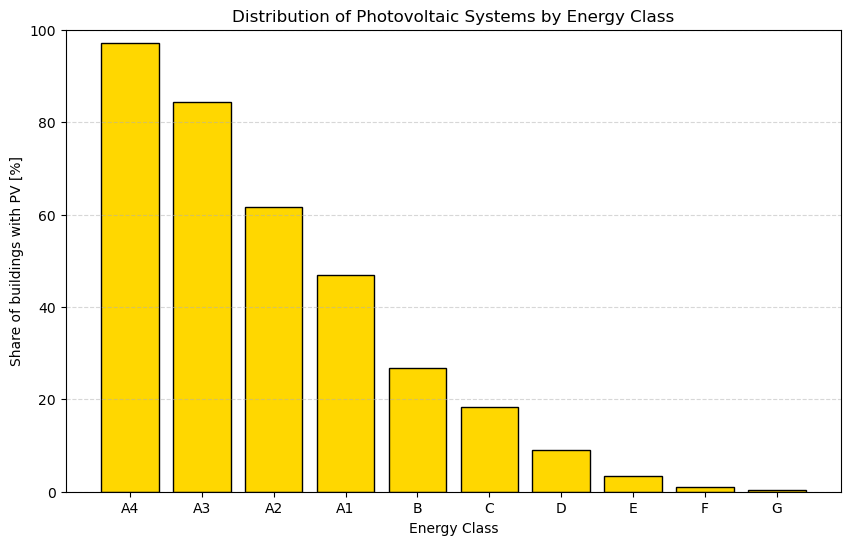

<Figure size 640x480 with 0 Axes>

In [44]:
# Get energy class for all rows
classe = df['CLASSE_ENERGETICA']

# Total buildings per class
total_by_class = classe.value_counts()

# Buildings with PV per class
pv_by_class = classe[has_pv].value_counts()

# Reorder based on standard energy class order
total_by_class = total_by_class.reindex(energy_classes, fill_value=0)
pv_by_class = pv_by_class.reindex(energy_classes, fill_value=0)

# Calculate percentage
pv_percentage = (pv_by_class / total_by_class * 100).fillna(0)

# Plot result
plt.figure(figsize=(10, 6))
plt.bar(pv_percentage.index, pv_percentage.values, color='gold', edgecolor='black')
plt.xlabel("Energy Class")
plt.ylabel("Share of buildings with PV [%]")
plt.title("Distribution of Photovoltaic Systems by Energy Class")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Save the plot as a PNG file
plt.savefig(working_path + "/Exports/PV_by_energy_class.png", dpi=300, bbox_inches='tight')

Average PV power of units with PDC: 4.30 kW


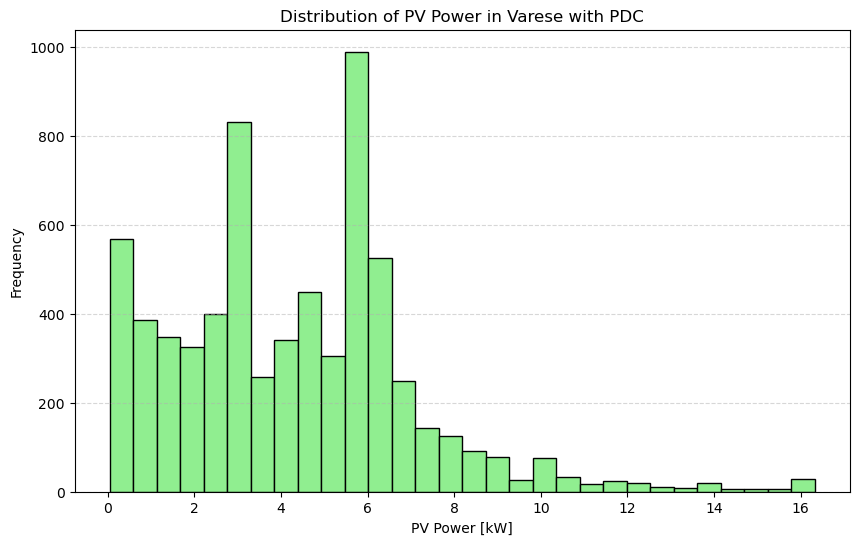

In [45]:
# PV power of units with PDC
pv_power_pdc = pv_power[has_pdc]
# Average PV power of units with PDC
print(f"Average PV power of units with PDC: {pv_power_pdc.mean():.2f} kW")
# Histogram of PV power of units with PDC
plt.figure(figsize=(10, 6))
plt.hist(pv_power_pdc, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel("PV Power [kW]")
plt.ylabel("Frequency")
plt.title("Distribution of PV Power in Varese with PDC")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save into report/figures
plt.savefig(working_path + "/Report/figures/1_pv_size_hp.png", dpi=300, bbox_inches='tight')

Average PV power of units without PDC: 3.70 kW


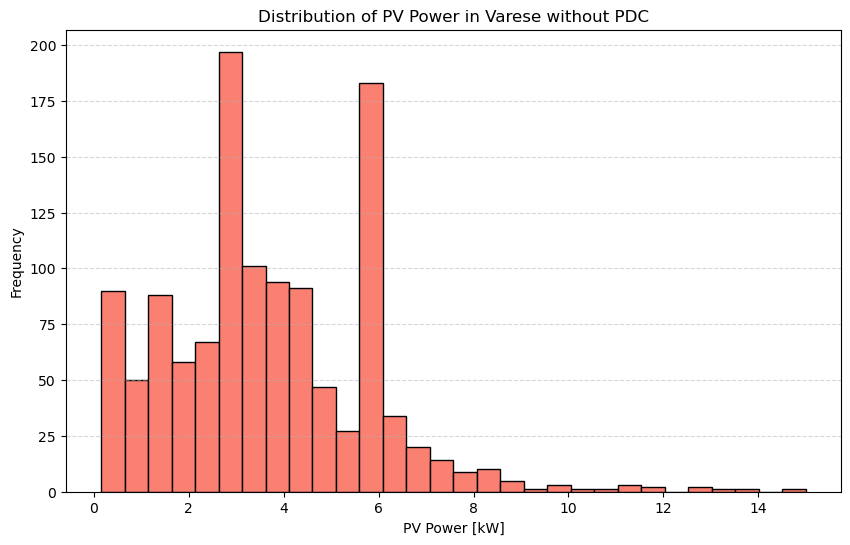

In [46]:
# Those without PDC
pv_power_no_pdc = pv_power[~has_pdc]
# Average PV power of units without PDC
print(f"Average PV power of units without PDC: {pv_power_no_pdc.mean():.2f} kW")
# Histogram of PV power of units without PDC
plt.figure(figsize=(10, 6))
plt.hist(pv_power_no_pdc, bins=30, color='salmon', edgecolor='black')
plt.xlabel("PV Power [kW]")
plt.ylabel("Frequency")
plt.title("Distribution of PV Power in Varese without PDC")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save into report/figures
plt.savefig(working_path + "/Report/figures/1_pv_size_no_hp.png", dpi=300, bbox_inches='tight')

In [47]:
# Print the distribution
print("/nDistribution of PV systems by energy class:")
for energy_class, percentage in pv_percentage.items():
    print(f"{energy_class}: {percentage:.2f}%")

# Save the data to data_save
data_save += "\nDistribution of PV systems by energy class:\n"
for energy_class, percentage in pv_percentage.items():
    data_save += f"{energy_class}: {percentage:.2f}%\n"

/nDistribution of PV systems by energy class:
A4: 97.03%
A3: 84.27%
A2: 61.70%
A1: 46.90%
B: 26.70%
C: 18.42%
D: 9.08%
E: 3.40%
F: 1.07%
G: 0.40%


## Evaluation of Electricity Balance

In [48]:
# Convert columns to float
insitu = df['CONSUMI_SOLARE_FOTOVOLTAICO'].astype(float)
imported = df['CONSUMI_ENERGIA_ELETTRICA'].astype(float)
exported = df['ENERGIA_ESPORTATA'].astype(float)

# Avoid division by zero
total_energy = insitu + imported
valid = total_energy > 0

# Compute metrics only for valid entries
self_consumption_factor = (insitu / total_energy * 100).where(valid)
over_Sizing_factor = ((exported-imported) / total_energy * 100).where(valid)

# Add to DataFrame
df['SCF_%'] = self_consumption_factor
df['OSF_%'] = over_Sizing_factor

# Group by energy class
grouped = df.groupby('CLASSE_ENERGETICA')[['SCF_%', 'OSF_%']].mean()

# Reorder and fill missing
grouped = grouped.reindex(energy_classes)

# Print the results
print("Stats Impianti Fotovoltaici:")
for energy_class, row in grouped.iterrows():
    print(f"{energy_class}: SCF = {(100 - row['SCF_%']):.2f}%, OSF = {(row['OSF_%']):.2f}%")

# Save the data to data_save
data_save += "\nStats Impianti Fotovoltaici:\n"
for energy_class, row in grouped.iterrows():
    data_save += f"{energy_class}: SCF = {(100 - row['SCF_%']):.2f}%, OSF = {(row['OSF_%']):.2f}%\n"

Stats Impianti Fotovoltaici:
A4: SCF = 38.49%, OSF = 65.47%
A3: SCF = 55.92%, OSF = 78.28%
A2: SCF = 68.32%, OSF = 299.50%
A1: SCF = 74.43%, OSF = 1029.90%
B: SCF = 80.71%, OSF = 966.47%
C: SCF = 84.49%, OSF = 434.58%
D: SCF = 90.84%, OSF = 111.82%
E: SCF = 96.08%, OSF = 120.58%
F: SCF = 98.85%, OSF = -67.53%
G: SCF = 99.76%, OSF = -95.48%


In [52]:
# Ensure columns are float
df['EP_GL_REN'] = df['EP_GL_REN'].astype(float)
df['EP_GL_NREN'] = df['EP_GL_NREN'].astype(float)

# Compute 99th percentiles
p99_ren = df['EP_GL_REN'].quantile(0.99)
p99_nren = df['EP_GL_NREN'].quantile(0.99)

# Filter out rows where either value exceeds its 99th percentile
df = df[(df['EP_GL_REN'] <= p99_ren) & (df['EP_GL_NREN'] <= p99_nren)]

print(df['EP_GL_REN'].mean())
print(df['EP_GL_NREN'].mean())

# Sum by energy class
ep_gl_sum_by_class = df.groupby('CLASSE_ENERGETICA')[['EP_GL_REN', 'EP_GL_NREN']].sum()
ep_gl_sum_by_class = ep_gl_sum_by_class.reindex(energy_classes, fill_value=0)

# Compute the average of the sum of the two EP_GL values per class
ep_gl_sum_by_class['EP_GL_TOTAL_AVG'] = (ep_gl_sum_by_class['EP_GL_REN'] + ep_gl_sum_by_class['EP_GL_NREN']) / 1000

# Print results
print("\nAverage of the sums (EP_GL_REN + EP_GL_NREN) per energy class:")
print(ep_gl_sum_by_class[['EP_GL_TOTAL_AVG']])

# Average of the sums (EP_GL_REN + EP_GL_NREN) per energy class
print(ep_gl_sum_by_class[['EP_GL_TOTAL_AVG']].mean())

# Save to data string
data_save += "\nAverage of the sums (EP_GL_REN + EP_GL_NREN) per energy class:\n"
for energy_class, row in ep_gl_sum_by_class.iterrows():
    data_save += f"{energy_class}: EP_GL_TOTAL_AVG = {row['EP_GL_TOTAL_AVG']:.2f}\n"


11.539973429149432
242.4147194963616

Average of the sums (EP_GL_REN + EP_GL_NREN) per energy class:
                   EP_GL_TOTAL_AVG
CLASSE_ENERGETICA                 
A4                       244.83288
A3                       191.42309
A2                       196.80014
A1                       234.48072
B                        239.17398
C                        369.22845
D                        826.90927
E                       1527.71308
F                       3448.44013
G                       9542.44921
EP_GL_TOTAL_AVG    1682.145095
dtype: float64


In [50]:
# Save to text file
with open(working_path + "/Exports/Data_Analysis_Output.txt", "w") as file:
    file.write(data_save)
    file.write("\n\n")